In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt

Importation du csv dans un dataframe

In [89]:
df_ = pd.read_csv('./online_retail_II.csv')
df = df_.copy()

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


Différentes remarques sur ces informations :
- La colonne 'InvoiceDate' est de type objet au lieu d'être en date.  
- La plupart des colonnes ont 1067371 lignes à l'exception de 'Description' et 'Customer ID', il y a donc des informations manquantes. La colonne 'Description' n'est pas vraiment utile, mais celle des 'Customer ID' étant primordiale nous allons supprimer les lignes où l'ID manque.  
- La colonne 'Customer ID' est de type float64 alors qu'un type int64 est certainement suffisant.  
- Il n'y a pas de colonne pour décrire le prix total en fonction de la quantité d'articles achetée, ce qui pourrait être une information intéressante.  

In [91]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

Voyons maintenant s'il y a des doublons, s'il y en a nous les supprimerons

In [92]:
df[df.duplicated()].shape

(34335, 8)

In [93]:
df = df.drop_duplicates(keep='first')
df[df.duplicated()].shape

(0, 8)

Suppression des lignes où le Customer ID est manquant et conversion du type en int64  
Création d'une colonne 'Total' pour avoir le prix selon la quantité achetée

In [94]:
df = df[df['Customer ID'].notna()]
df['Customer ID'] = df['Customer ID'].astype(np.int64)
df['Total'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


# Analyse des performances de l'entreprise et des tendances globales
## Analyse produits

Il peut être intéressant de voir quel est le produit qui a le prix le plus élevé

In [95]:
most_expensive = df.loc[df['Price'] == df['Price'].max()]
most_expensive 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total
748142,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.0,15098,United Kingdom,-38970.0


On remarque ici que le produit en question a une description particulière, et surtout que la quantité est de -1, il s'agit certainement d'un remboursement qui aurait été fait manuellement ('Manuel' en description)?

Maintenant intéressons-nous aux produits avec le prix le plus bas.

In [96]:
least_expensive = df.loc[df['Price'] == df['Price'].min()]
least_expensive = least_expensive.groupby(['Description', 'Price'], as_index=False)['Quantity'].agg('sum')
least_expensive 

,Description,Price,Quantity
0,FLAMINGO LIGHTS,0.0,24
1,OVAL WALL MIRROR DIAMANTE,0.0,1
2,36 FOIL STAR CAKE CASES,0.0,144
3,6 RIBBONS EMPIRE,0.0,12
4,ADVENT CALENDAR GINGHAM SACK,0.0,4
...,...,...,...
56,SET/5 RED SPOTTY LID GLASS BOWLS,0.0,2
57,TV DINNER TRAY DOLLY GIRL,0.0,9
58,This is a test product.,0.0,10
59,VINTAGE CREAM CAT FOOD CONTAINER,0.0,1


On peut voir ici qu'il y a 61 produits dont le prix est affiché à 0, voyons plutôt ce qu'on trouve comme produit si on fait abstraction de ceux qui sont gratuits

In [97]:
df_non_zero_price = df.loc[df['Price'] != 0]
least_expensive_not_null = df_non_zero_price.loc[df_non_zero_price['Price'] == df_non_zero_price['Price'].min()]
least_expensive_not_null = least_expensive_not_null.groupby(['Description', 'Price'], as_index=False)['Quantity'].agg('sum')
least_expensive_not_null

,Description,Price,Quantity
0,Bank Charges,0.001,1
1,PADS TO MATCH ALL CUSHIONS,0.001,17


Cherchons maintenant après les 10 produits les plus vendus et les 10 produits sur lesquels il y a le plus de retours.  
Nous prenons le temps de retirer les produits qui ont pour description 'CRUK Commission' (une organisation de recherches sur les cancers) ainsi que 'Discount'.

In [98]:
df_products = df.groupby(['Description'], as_index=False)['Quantity'].agg('sum')
df_products = df_products.loc[~df_products['Description'].isin(['CRUK Commission', 'Discount'])]
df_products_asc = df_products.sort_values('Quantity').head(10)
df_products_asc['Quantity'] = df_products_asc['Quantity'] * (-1)
df_products_desc = df_products.sort_values('Quantity', ascending=False).head(10)

In [99]:
fig = go.Figure(data=[
    go.Bar(name='Produits les plus vendus', 
           x=df_products_desc['Description'].astype(str), 
           y=df_products_desc['Quantity'],
           marker_opacity=1,
           marker={'color': df_products_desc['Quantity'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_layout(title='Produits les plus vendus',
                  title_x=0.45,
                  xaxis_title="Produits",
                  yaxis_title="Quantité vendue",
                  plot_bgcolor='white')
fig.show()

In [100]:
fig = go.Figure(data=[
    go.Bar(name='Produits avec le plus de retours', 
           x=df_products_asc['Description'].astype(str), 
           y=df_products_asc['Quantity'],
           marker_opacity=1,
           marker={'color': df_products_desc['Quantity'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_layout(title='Produits avec le plus de retours',
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Produits",
                  yaxis_title="Quantité retournée",
                  plot_bgcolor='white')
fig.show()

On observe ici que le produit le plus vendu est le 'World War 2 Glider', on voit également que parmis les produits les plus vendus il y a plusieurs boîtes à gâteau.  
A l'inverse ce sont les 'white cherry lights' qui ont fait l'objet du plus grand nombre de retours, parmis les produits les plus retournés on peut voir qu'il y a beaucoup de décorations.

## Analyse clients
Cherchons maintenant après les 10 clients qui ont dépensé le plus au cours de ces deux ans, ainsi que les 10 qui ont dépensé le moins

In [101]:
df_customers = df.groupby(['Customer ID', 'Country'], as_index=False)['Total'].agg('sum')
df_customers_asc = df_customers.sort_values('Total').head(10)
df_customers_desc = df_customers.sort_values('Total', ascending=False).head(10)

In [102]:
fig = go.Figure(data=[
    go.Bar(name='Clients qui ont le plus acheté', 
           x=df_customers_desc['Customer ID'].astype(str), 
           y=df_customers_desc['Total'],
           marker_opacity=1,
           hovertext=df_customers_desc['Country'],
           marker={'color': df_customers_desc['Total'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_layout(title='Clients qui ont le plus acheté',
                  title_x=0.45,
                  xaxis_title="Customer ID",
                  yaxis_title="Montant Total",
                  plot_bgcolor='white')
fig.show()

On peut voir que le client avec l'ID 18102 est celui qui a dépensé le plus ces deux dernières années avec près de 600k, on sait également qu'il vient du Royaume Uni.  
Parmis les 10 meilleurs clients, la plupart viennent du Royaume Uni ou d'Irlande

In [103]:
fig = go.Figure(data=[
    go.Bar(name='Clients qui ont le moins acheté', 
           x=df_customers_asc['Customer ID'].astype(str), 
           y=df_customers_asc['Total'],
           marker_opacity=1,
           hovertext=df_customers_desc['Country'],
           marker={'color': df_customers_desc['Total'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_layout(title='Clients qui ont le moins acheté',
                  title_x=0.45,
                  xaxis_title="Customer ID",
                  yaxis_title="Montant Total Remboursé",
                  plot_bgcolor='white')
fig.show()

On peut voir ici que le client avec l'ID 17399 est celui qui a reçu le plus gros remboursement, pour près de 25k.  
Tout comme pour les meilleurs clients, les moins bons ont l'air de venir pour la plupart du Royaume-Uni ainsi que de l'Irlande.

Il pourrait être intéressant de voir maintenant quels sont les pays dont les clients ont le plus et le moins acheté.

In [104]:
df_countries_purchase = df.groupby(['Country'], as_index=False)['Total'].agg('sum')
df_countries_purchase_asc = df_countries_purchase.sort_values('Total').head(10)
df_countries_purchase_desc = df_countries_purchase.sort_values('Total', ascending=False).head(10)

In [105]:
fig = go.Figure(data=[
    go.Bar(name="Pays avec le plus d'achats", 
           x=df_countries_purchase_desc['Country'].astype(str), 
           y=df_countries_purchase_desc['Total'],
           marker_opacity=1,
           marker={'color': df_countries_purchase_desc['Total'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_layout(title="Pays avec le plus d'achats",
                  title_x=0.45,
                  xaxis_title="Pays",
                  yaxis_title="Montant Total",
                  plot_bgcolor='white')
fig.show()

In [106]:
fig = go.Figure(data=[
    go.Bar(name="Pays avec le moins d'achats", 
           x=df_countries_purchase_asc['Country'].astype(str), 
           y=df_countries_purchase_asc['Total'],
           marker_opacity=1,
           marker={'color': df_countries_purchase_desc['Total'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_layout(title="Pays avec le moins d'achats",
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Pays",
                  yaxis_title="Montant Total",
                  plot_bgcolor='white')
fig.show()

On observe ici que le Royaume Uni est loin devant en terme de dépenses, avec près de 13.5M d'achat soit 24x plus que l'Irlande qui arrive en seconde position.  
A l'inverse, l'Arabie Saoudite est le pays où les clients ont le moins dépensé : seulement 131 € sur ces deux dernières années.  
On peut également être étonné du positionnement de la République Tchèque parmis les pays qui ont le moins dépensé alors que la plupart des autres pays d'Europe sont parmis le top 10.

Nous allons maintenant nous intéresser aux pays où le nombre unique de clients est le plus élevé et ceux où il est le moins élevé.

In [107]:
df_countries_customers = df.groupby(['Country'], as_index=False)['Customer ID'].agg({'Customer ID': 'nunique'})
df_countries_customers.rename(columns={'Customer ID': 'Customer Count'}, inplace=True)
df_countries_customers_asc = df_countries_customers.sort_values('Customer Count').head(10)
df_countries_customers_desc = df_countries_customers.sort_values('Customer Count', ascending=False).head(10)

In [108]:
fig = go.Figure(data=[
    go.Bar(name='Pays avec le plus grand nombre de clients uniques', 
           x=df_countries_customers_desc['Country'].astype(str), 
           y=df_countries_customers_desc['Customer Count'],
           marker_opacity=1,
           marker={'color': df_countries_customers_desc['Customer Count'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_layout(title='Pays avec le plus grand nombre de clients uniques',
                  title_x=0.45,
                  xaxis_title="Pays",
                  yaxis_title="Nombre de clients uniques",
                  plot_bgcolor='white')
fig.show()

In [109]:
fig = go.Figure(data=[
    go.Bar(name='Pays avec le plus petit nombre de clients uniques', 
           x=df_countries_customers_asc['Country'].astype(str), 
           y=df_countries_customers_asc['Customer Count'],
           marker_opacity=1,
           marker={'color': df_countries_customers_desc['Customer Count'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_layout(title='Pays avec le plus petit nombre de clients uniques',
                  title_x=0.45,
                  xaxis_title="Pays",
                  yaxis_title="Nombre de clients uniques",
                  plot_bgcolor='white')
fig.show()

On voit ici que dans le Royaume Uni il y a eu 5410 clients uniques au cours de ces 2 dernières années, ce qui est près de 50x plus que l'Allemagne ou la France qui sont à environ 100 clients uniques.  
Pour ce qui est des pays avec le moins de clients uniques, on peut voir que dans ces 10 pays il n'y a eu qu'un seul client.

# Création du RFM

RFM ? Récence, Fréquence, Montant.

Récence : la date du dernier achat. Notez bien que l’on part du principe qu’une personne qui a acheté récemment chez vous a plus de chances de revenir commander chez vous.  

Fréquence : le nombre d’achats réalisé sur une période donnée. Plus un client achète régulièrement chez vous, plus il y a de chances pour qu’il achète à nouveau. Vous l’avez compris, on analyse ici son niveau de fidélité.  

Montant : la somme des achats cumulés sur une période donnée. Les gros acheteurs répondent mieux que les petits. On mesure ici la valeur client.

Trouver la date la plus récente

In [110]:
date_recente = df["InvoiceDate"].max()
print(date_recente)

2011-12-09 12:50:00


### Préparation des données RFM

In [117]:
# Calculer les valeurs RFM sur l'ensemble de la plage de dates
last_date = df["InvoiceDate"].max()
recency = (last_date - df.groupby("Customer ID")["InvoiceDate"].max()).dt.days
frequency = df.groupby("Customer ID")["Invoice"].nunique()
monetary_value = df.groupby("Customer ID")["Total"].sum()

# Créer un nouveau DataFrame avec les valeurs RFM
rfm_df = pd.DataFrame({
    "Recency": recency,
    "Frequency": frequency,
    "MonetaryValue": monetary_value
})


print(rfm_df.head(100))

             Recency  Frequency  MonetaryValue
Customer ID                                   
12346            325         17         -51.74
12347              1          8        4921.53
12348             74          5        2019.40
12349             18          5        4404.54
12350            309          1         334.40
...              ...        ...            ...
12441            366          1         173.55
12442              2          1         172.06
12443            731          1         485.31
12444             20          5        5005.46
12445             21          3         426.48

[100 rows x 3 columns]


Scoring Rfm

In [119]:
# scoring_rfm_df = rfm_df

# # Définir les poids pour chaque critère RFM
# weights = {
#     "Recency": 0.4,
#     "Frequency": 0.3,
#     "MonetaryValue": 0.3
# }

# # Définir les classes pour chaque critère RFM
# recency_classes = pd.cut(scoring_rfm_df["Recency"], bins=5, labels=[1, 2, 3, 4, 5])
# frequency_classes = pd.cut(scoring_rfm_df["Frequency"], bins=5, labels=[1, 2, 3, 4, 5])
# monetary_value_classes = pd.cut(scoring_rfm_df["MonetaryValue"], bins=5, labels=[1, 2, 3, 4, 5])

# # Fonction pour attribuer le score RFM
# def calculate_rfm_score(row):
#     recency_score = recency_classes[row.name]
#     frequency_score = frequency_classes[row.name]
#     monetary_value_score = monetary_value_classes[row.name]
#     return recency_score * weights["Recency"] + frequency_score * weights["Frequency"] + monetary_value_score * weights["MonetaryValue"]

# # Appliquer la fonction pour calculer le score RFM
# scoring_rfm_df["RFM Score"] = scoring_rfm_df.apply(calculate_rfm_score, axis=1)

# # Classer le DataFrame RFM par score RFM
# scoring_rfm_df = scoring_rfm_df.sort_values("RFM Score", ascending=False)

# # Afficher le DataFrame RFM classé par score RFM
# print(scoring_rfm_df.head(100))

### Normalisation des données

In [120]:
from sklearn.preprocessing import StandardScaler

# Normaliser les valeurs RFM
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df)

### Nombre de clusters : méthode du coude

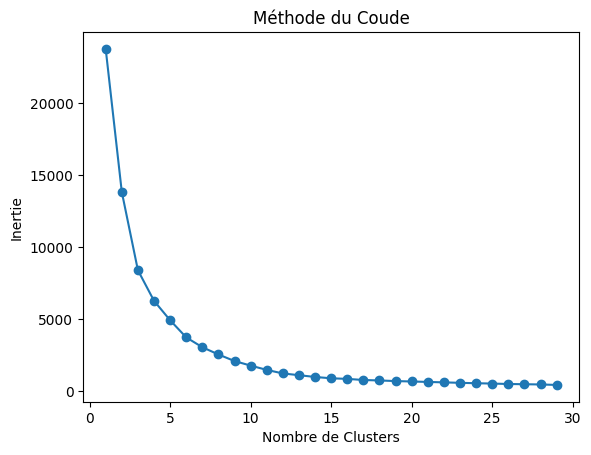

In [138]:
# Liste pour stocker les valeurs d'inertie
inertias = []

# Essayer différents nombres de clusters
for n_clusters in range(1, 30):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(rfm_normalized)
    inertias.append(kmeans.inertia_)

# Tracer le graphique de l'inertie en fonction du nombre de clusters
plt.plot(range(1, 30), inertias, marker='o')
plt.title("Méthode du Coude")
plt.xlabel("Nombre de Clusters")
plt.ylabel("Inertie")
plt.show()

### Application du clustering (avec K-means)

In [139]:
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(rfm_normalized)

### Réduction de dimension avec T-SNE

In [140]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(rfm_normalized)

### Visualisation des clusters ave T-SNE

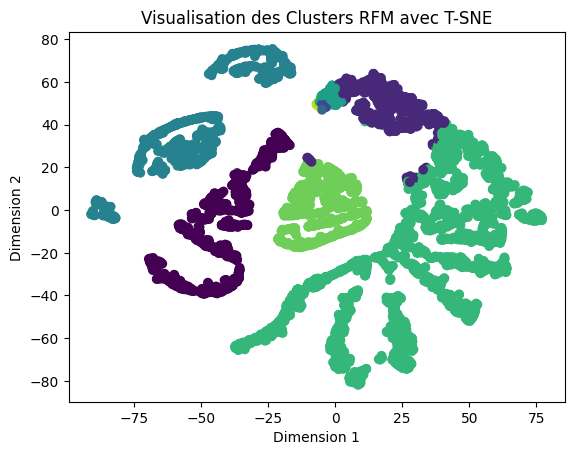

In [141]:
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=clusters, cmap="viridis")
plt.title("Visualisation des Clusters RFM avec T-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()
